# Description

This code is an interactive version of Array2Corridors.py ; Its purpose is to help you understand the code and to troubleshoot it if needed by executing it step by step and visualizing the intermediate results.

## 1. Importing the necessary libraries and defining the paths used in the code

In [2]:
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import cv2
import os
import re
from tqdm import tqdm
import cv2
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import mpldatacursor
import more_itertools as mit
from pathlib import Path
import os
from scipy import signal
import shutil

import re
from tqdm import tqdm
import subprocess

In [2]:
# Path definitions

inputfolder = Path("/Volumes/Ramdya-Lab/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/Feeding_state/230704_FeedingState_1_AM/")


## 2. Loading the data and preparing the data structures

In [3]:
%matplotlib qt

# Load the first frame
frame = cv2.imread(inputfolder.joinpath("image0.jpg").as_posix())

# If it's not already, make it grayscale
if len(frame.shape) > 2:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# equalize the histogram to make thresholding easier
frame = cv2.equalizeHist(frame)

# rotate the image 90 degrees
#frame = np.rot90(frame)

# display the frame
fig, ax = plt.subplots()
plt.axis('off')
im = ax.imshow(frame, cmap="gray", vmin=0, vmax=255)

mpldatacursor.datacursor()

plt.show()


## 3. Find the arenas in the image

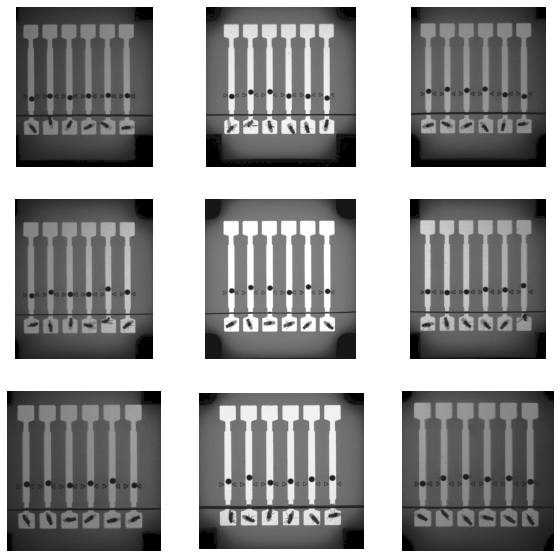

In [40]:
%matplotlib inline
# Define and store the arena edges from the peaks locations
# xcoords = colbounds[0]
# ycoords = rowbounds[0]

X1 = 0
X2 = 620
X3 = 1450
X4 = 2130
X5 = 2980
X6 = 3590

Y1 = 0
Y2 = 725
Y3 = 1140
Y4 = 1860
Y5 = 2350
Y6 = 2995

regions_of_interest = [
    (X1, Y1, X2, Y2),
    (X3, Y1, X4, Y2),
    (X5, Y1, X6, Y2),
    (X1, Y3, X2, Y4),
    (X3, Y3, X4, Y4),
    (X5, Y3, X6, Y4),
    (X1, Y5, X2, Y6),
    (X3, Y5, X4, Y6),
    (X5, Y5, X6, Y6),
]

# Plot the regions of interest on the frame

# fig, axs = plt.subplots(3, 3, figsize = (10,10))
# for i, ax in enumerate(axs.flat):
#     ax.axis('off')
#     ax.imshow(
#         frame[
#             regions_of_interest[i][1] : regions_of_interest[i][3],
#             regions_of_interest[i][0] : regions_of_interest[i][2],
#         ],
#         cmap="gray",
#         vmin=0,
#         vmax=255,
#     )
    


# plt.show()
fig = plt.figure(figsize=(10,10))

for i in range(len(regions_of_interest)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.axis('off')
    ax.imshow(
        frame[
            regions_of_interest[i][1] : regions_of_interest[i][3],
            regions_of_interest[i][0] : regions_of_interest[i][2],
        ],
        cmap="gray",
        vmin=0,
        vmax=255,
    )

plt.show()


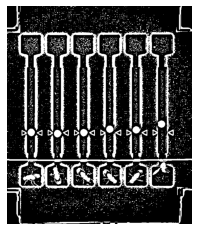

In [42]:
subset = np.array(
    frame[
        regions_of_interest[5][1] : regions_of_interest[5][3],
        regions_of_interest[5][0] : regions_of_interest[5][2],
    ]
)
Thresh = subset.copy()
# Apply an adaptive threshold to each subset to keep only the brightest pixels
Thresh = cv2.adaptiveThreshold(
    Thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 4
)
# plot the thresholded image
fig, ax = plt.subplots()
plt.axis('off')
im = ax.imshow(Thresh, cmap="gray", vmin=0, vmax=255)

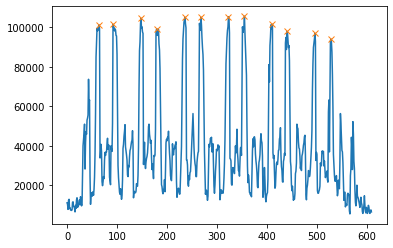

In [44]:
cols = Thresh.sum(axis=0)
rows = subset.sum(axis=1)

colpeaks = signal.find_peaks(
    cols,
    distance=20,
    height=(90_000, 120_000),
    # width=(5, 30),
)
colpeaks = (colpeaks[0], colpeaks[1])

# plot cols with the colpeaks
fig, ax = plt.subplots()
#plt.axis('off')
ax.plot(cols)
ax.plot(colpeaks[0], colpeaks[1]["peak_heights"], "x")
plt.show()



In [23]:
colpeaks

(array([ 99, 132, 184, 217, 269, 304, 357, 391, 444, 477, 530, 562]),
 {'peak_heights': array([106590., 102000., 101745.,  99705., 100725.,  98175., 101745.,
         104550., 102255.,  99450., 101235.,  96900.])})

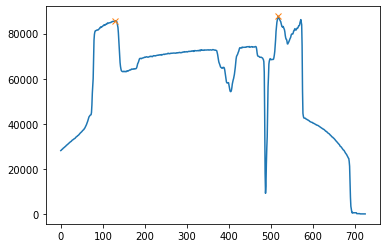

In [27]:
rowpeaks = signal.find_peaks(
        rows,
        distance=200,
    )
rowpeaks = (rowpeaks[0], rowpeaks[1])

# plot rows with the rowpeaks
fig, ax = plt.subplots()
#plt.axis('off')
ax.plot(rows)
ax.plot(rowpeaks[0], rows[rowpeaks[0]], "x")
plt.show()

In [24]:
rowpeaks

(array([130, 517]), {})

In [45]:
# For each subset, find the cols and rows peaks and store the even peaks in a list
Corridors = []
for i in range(len(regions_of_interest)):
    subset = np.array(
        frame[
            regions_of_interest[i][1] : regions_of_interest[i][3],
            regions_of_interest[i][0] : regions_of_interest[i][2],
        ]
    )
    Thresh = subset.copy()
    # Apply an adaptive threshold to each subset to keep only the brightest pixels
    Thresh = cv2.adaptiveThreshold(
        Thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 4
    )

    cols = Thresh.sum(axis=0)
    rows = subset.sum(axis=1)

    colpeaks = signal.find_peaks(
        cols,
        distance=20,
        height=(90_000, 120_000),
        # width=(5, 30),
    )
    colpeaks = (colpeaks[0], colpeaks[1])

    rowpeaks = signal.find_peaks(
        rows,
        distance=300,
    )
    #######################################################
    Colpos = []
    Rowpos = []

    for peak_index in colpeaks[0]:
        peak_x = regions_of_interest[i][0] + peak_index
        peak_y = np.argmax(subset[peak_index])
        peak_y += regions_of_interest[i][1]
        Colpos.append((peak_x, peak_y))

    for peak_index in rowpeaks[0]:
        peak_x = np.argmax(subset[peak_index])
        peak_x += regions_of_interest[i][0]
        peak_y = regions_of_interest[i][1] + peak_index
        Rowpos.append((peak_x, peak_y))

    bound_x = 30
    bound_y = 50

    subcors = [
        (
            Colpos[0][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[1][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[2][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[3][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[4][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[5][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[6][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[7][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[8][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[9][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[10][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[11][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
    ]

    # subcors = generate_subsets(subset, regions_of_interest)

    Corridors.append(subcors)

IndexError: list index out of range

Here I add a check to modify crops that could generate images with odd dimensions. This is not necessary but it makes the generated images easier to interface with ffmpeg.

In [29]:
def modify_corridors(Corridors):
    for i in range(len(Corridors)):
        for j in range(len(Corridors[i])):
            corridor = list(Corridors[i][j])
            height = corridor[3] - corridor[1]
            width = corridor[2] - corridor[0]
            if height % 2 != 0:
                corridor[3] += 1
            if width % 2 != 0:
                corridor[2] += 1
            Corridors[i][j] = tuple(corridor)
    return Corridors


Corridors = modify_corridors(Corridors)

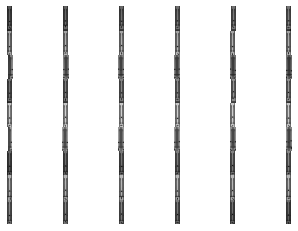

In [30]:
# Same as above but with the corrected corridors
fig, axs = plt.subplots(9, 6)
for i in range(9):
    for j in range(6):
        axs[i, j].axis("off")
        axs[i, j].imshow(
            frame[
                Corridors[i][j][1] : Corridors[i][j][3],
                Corridors[i][j][0] : Corridors[i][j][2],
            ],
            cmap="gray",
            vmin=0,
            vmax=255,
        )
        
# Remove the axis of each subplot and draw them closer together
for ax in axs.flat:
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

# All first steps in one go

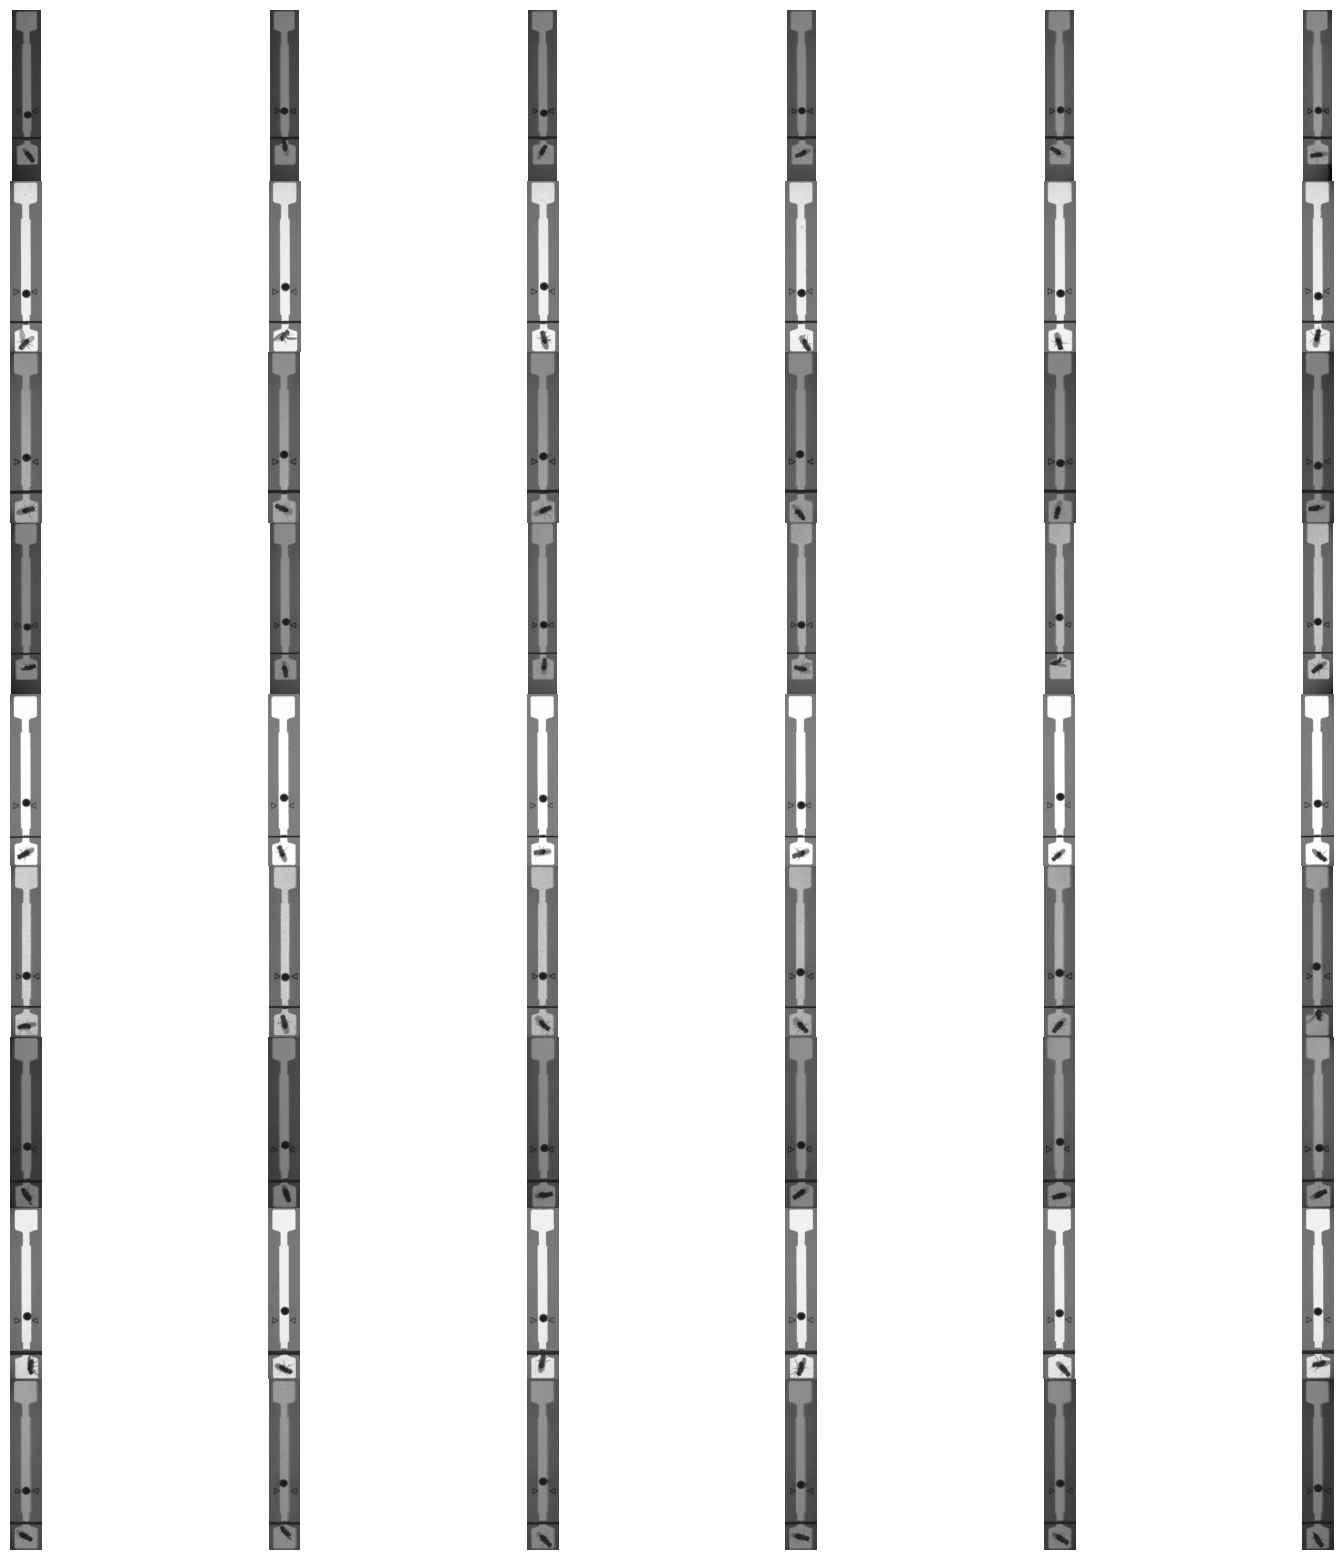

In [11]:
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import cv2
import os
import re
from tqdm import tqdm
import cv2
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import mpldatacursor
import more_itertools as mit
from pathlib import Path
import os
from scipy import signal
import shutil

import re
from tqdm import tqdm
import subprocess

# Path definitions

inputfolder = Path("/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/Feeding_state/230704_FeedingState_1_AM/")

# Load the first frame
frame = cv2.imread(inputfolder.joinpath("image0.jpg").as_posix())

# If it's not already, make it grayscale
if len(frame.shape) > 2:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# equalize the histogram to make thresholding easier
frame = cv2.equalizeHist(frame)

# Crop the image to the regions of interest

X1 = 0
X2 = 620
X3 = 1450
X4 = 2130
X5 = 2980
X6 = 3590

Y1 = 0
Y2 = 725
Y3 = 1140
Y4 = 1860
Y5 = 2350
Y6 = 2995

regions_of_interest = [
    (X1, Y1, X2, Y2),
    (X3, Y1, X4, Y2),
    (X5, Y1, X6, Y2),
    (X1, Y3, X2, Y4),
    (X3, Y3, X4, Y4),
    (X5, Y3, X6, Y4),
    (X1, Y5, X2, Y6),
    (X3, Y5, X4, Y6),
    (X5, Y5, X6, Y6),
]

# For each subset, find the cols and rows peaks and store the even peaks in a list
Corridors = []
for i in range(len(regions_of_interest)):
    subset = np.array(
        frame[
            regions_of_interest[i][1] : regions_of_interest[i][3],
            regions_of_interest[i][0] : regions_of_interest[i][2],
        ]
    )
    Thresh = subset.copy()
    # Apply an adaptive threshold to each subset to keep only the brightest pixels
    Thresh = cv2.adaptiveThreshold(
        Thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 4
    )

    cols = Thresh.sum(axis=0)
    rows = subset.sum(axis=1)

    colpeaks = signal.find_peaks(
        cols,
        distance=20,
        height=(80_000, 120_000),
        # width=(5, 30),
    )
    colpeaks = (colpeaks[0], colpeaks[1])

    rowpeaks = signal.find_peaks(
        rows,
        distance=300,
    )
    #######################################################
    Colpos = []
    Rowpos = []

    for peak_index in colpeaks[0]:
        peak_x = regions_of_interest[i][0] + peak_index
        peak_y = np.argmax(subset[peak_index])
        peak_y += regions_of_interest[i][1]
        Colpos.append((peak_x, peak_y))

    for peak_index in rowpeaks[0]:
        peak_x = np.argmax(subset[peak_index])
        peak_x += regions_of_interest[i][0]
        peak_y = regions_of_interest[i][1] + peak_index
        Rowpos.append((peak_x, peak_y))

    bound_x = 30
    bound_y = 60

    subcors = [
        (
            Colpos[0][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[1][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[2][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[3][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[4][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[5][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[6][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[7][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[8][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[9][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[10][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[11][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
    ]

    # subcors = generate_subsets(subset, regions_of_interest)

    Corridors.append(subcors)
    
def modify_corridors(Corridors):
    for i in range(len(Corridors)):
        for j in range(len(Corridors[i])):
            corridor = list(Corridors[i][j])
            height = corridor[3] - corridor[1]
            width = corridor[2] - corridor[0]
            if height % 2 != 0:
                corridor[3] += 1
            if width % 2 != 0:
                corridor[2] += 1
            Corridors[i][j] = tuple(corridor)
    return Corridors


Corridors = modify_corridors(Corridors)


# Same as above but with the corrected corridors
fig, axs = plt.subplots(9, 6, figsize=(20, 20))
for i in range(9):
    for j in range(6):
        axs[i, j].axis("off")
        axs[i, j].imshow(
            frame[
                Corridors[i][j][1] : Corridors[i][j][3],
                Corridors[i][j][0] : Corridors[i][j][2],
            ],
            cmap="gray",
            vmin=0,
            vmax=255,
        )
        
# Remove the axis of each subplot and draw them closer together
for ax in axs.flat:
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

<Figure size 2000x1000 with 0 Axes>

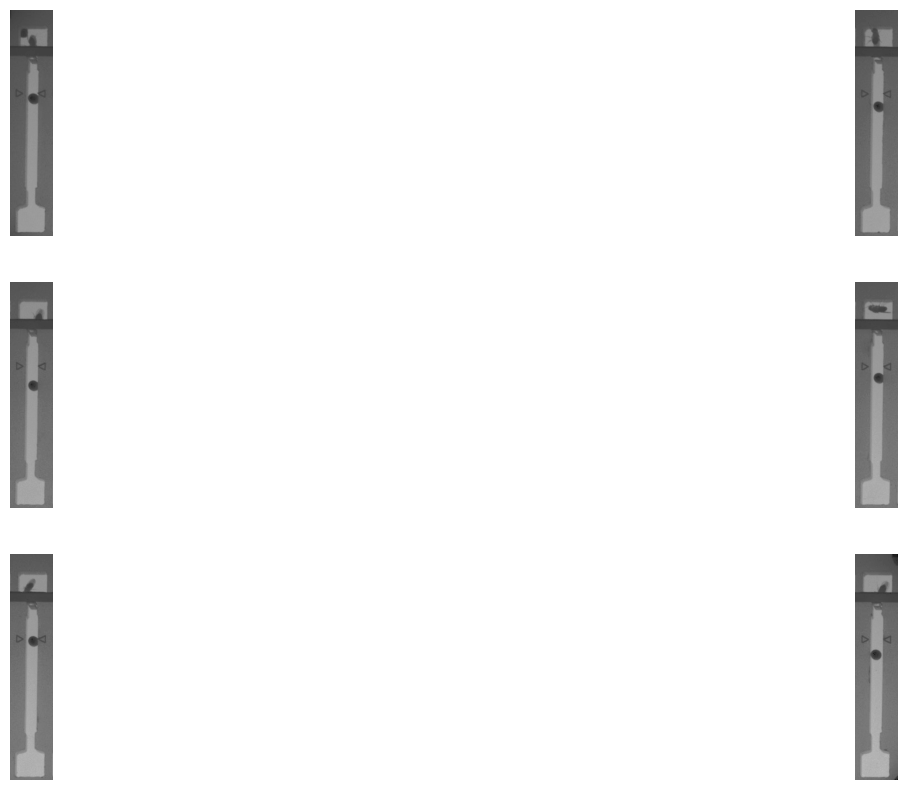

In [19]:
# increase plot size
plt.rcParams["figure.figsize"] = (20, 10)
# Reduce the space between subplots
plt.subplots_adjust(wspace=0, hspace=0)
# As an example, display all the corridors from Corridors[0] in a grid based on the frame
fig, axs = plt.subplots(3, 2)
for i, ax in enumerate(axs.flat):
    ax.axis("off")
    ax.imshow(
        frame[
            Corridors[0][i][1] : Corridors[0][i][3],
            Corridors[0][i][0] : Corridors[0][i][2],
        ],
        cmap="gray",
        vmin=0,
        vmax=255,
    )

# 4. Use the generated coordinates to save corridor crops for each frame of the video

  0%|          | 0/14 [00:00<?, ?it/s]

<Figure size 3000x2000 with 0 Axes>

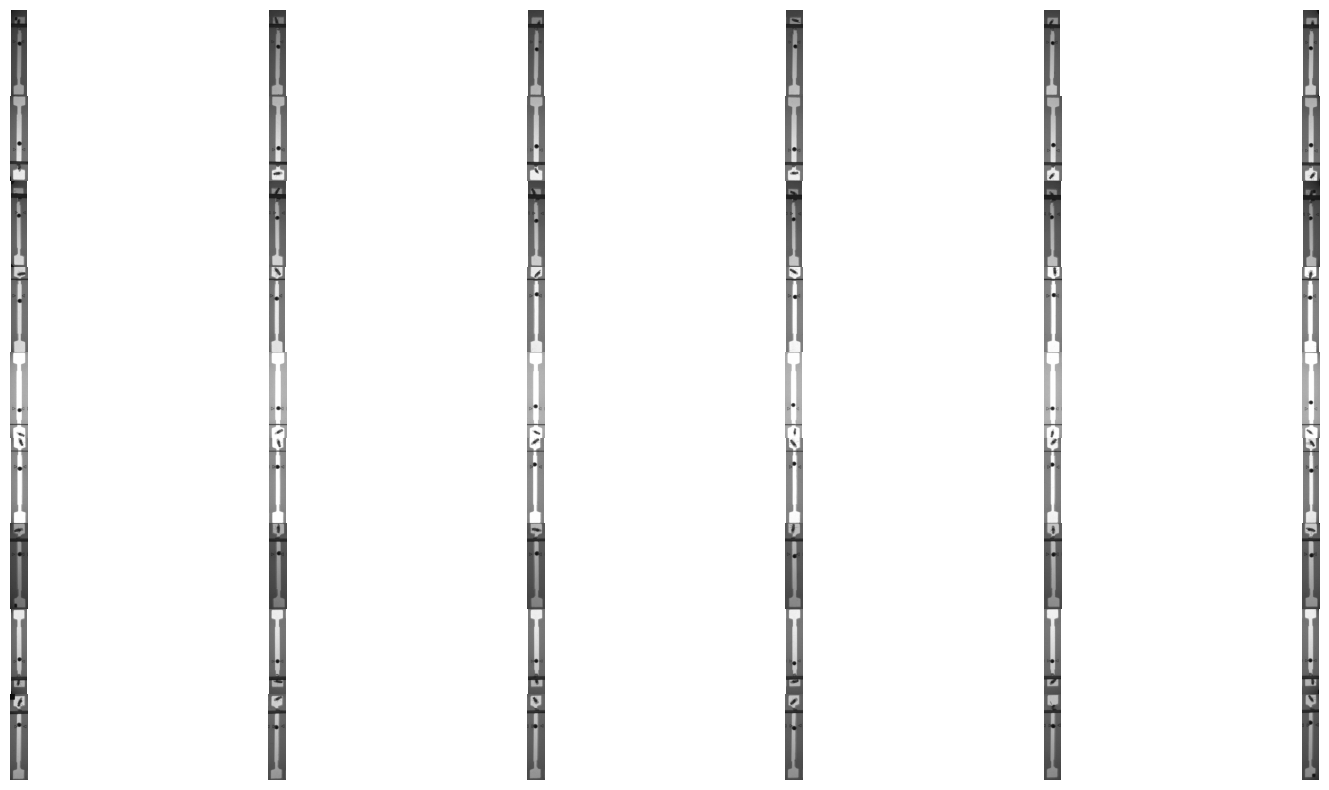

100%|██████████| 14/14 [00:01<00:00, 12.68it/s]


In [27]:
# Create a list of all the images in the target folder
folder = Path("/home/matthias/Videos/Subset_Test2/")
processedfolder = Path("/home/matthias/Videos/Subset_Test2_Cropped/")

# Create the subfolder if it doesn't exist
processedfolder.mkdir(exist_ok=True)

# Get a list of all image files in the input folder
images = [f.name for f in folder.glob("*") if f.is_file()]

# Sort the list of images by their number
images.sort(key=lambda f: int(re.sub("\D", "", f)))

for i, image in tqdm(enumerate(images), total=len(images)):
    # Read and process the image
    frame = cv2.imread(str(folder / image))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = np.rot90(frame)

    for j, subset in enumerate(Corridors):
        for k, corridor in enumerate(subset):
            # Create the subfolder if it doesn't exist
            subfolder = processedfolder / f"arena{j+1}" / f"corridor_{k+1}"
            subfolder.mkdir(parents=True, exist_ok=True)

            # Crop the image
            x1, y1, x2, y2 = corridor
            cropped_image = frame[y1:y2, x1:x2]

            # Save the cropped image
            cropped_image_file = f"{Path(image).stem}_cropped.jpg"
            cv2.imwrite(str(subfolder / cropped_image_file), cropped_image)
            
    if i == 0:
        plt.rcParams['figure.figsize'] = [20, 10]

        # Draw a bigger plotting area to display the corridors
        plt.figure(figsize=(30, 20))

        # Display all the crops corresponding to the corridors of each arena

        fig, axs = plt.subplots(9, 6)
        for u in range(9):
            for j in range(6):
                axs[u, j].imshow(
                    frame[
                        Corridors[u][j][1] : Corridors[u][j][3],
                        Corridors[u][j][0] : Corridors[u][j][2],
                    ],
                    cmap="gray",
                    vmin=0,
                    vmax=255,
                )
                
        # Remove the axis of each subplot and draw them closer together
        for ax in axs.flat:
            ax.axis("off")
        plt.subplots_adjust(wspace=0, hspace=0)



        plt.show()

Once we checked that everything is working fine on the subset, we can run the code on the whole sample

In [14]:
# Create a list of all the images in the target folder
folder = inputfolder
processedfolder = inputfolder.parent / f"{inputfolder.stem}_Cropped"

# Create the subfolder if it doesn't exist
#processedfolder.mkdir(exist_ok=True)
processedfolder.joinpath("testing")

PosixPath('/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/Feeding_state/230704_FeedingState_1_AM_Cropped/testing')

In [14]:


def process_image(image):
    # Read and process the image
    frame = cv2.imread(str(folder / image))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #frame = np.rot90(frame)

    for j, subset in enumerate(Corridors):
        for k, corridor in enumerate(subset):
            # Get the subfolder for this arena and corridor
            subfolder = processedfolder / f"arena{j+1}" / f"corridor_{k+1}"

            # Crop the image
            x1, y1, x2, y2 = corridor
            cropped_image = frame[y1:y2, x1:x2]

            # Save the cropped image
            cropped_image_file = f"{Path(image).stem}_cropped.jpg"
            cv2.imwrite(str(subfolder / cropped_image_file), cropped_image)



# Create the subfolder if it doesn't exist
processedfolder.mkdir(exist_ok=True)

# Get a list of all image files in the input folder
images = [f.name for f in folder.glob("*.[jJ][pP][gG]") if f.is_file()]

# Sort the list of images by their number
images.sort(key=lambda f: int(re.sub("\D", "", f)))

# Create the subfolders for each arena and corridor
for j, subset in enumerate(Corridors):
    for k, corridor in enumerate(subset):
        subfolder = processedfolder / f"arena{j+1}" / f"corridor_{k+1}"
        subfolder.mkdir(parents=True, exist_ok=True)

# Process the images in parallel using a process pool
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_image, images), total=len(images)))

100%|██████████| 54000/54000 [04:02<00:00, 222.54it/s]


# Video writing

Optional: subsetting

In [18]:
subpath = processedfolder.parent / f"{processedfolder.stem}_Subsets"

In [19]:
# Create the subfolder if it doesn't exist
subpath.mkdir(exist_ok=True)

# Compute the number of images corresponding to 15 minutes
n_images = 15 * 60 * 30

# For each corridor folder in the processed folder, create a subset folder with only n_images images

for arena in processedfolder.glob("arena*"):
    for corridor in arena.glob("corridor*"):
        # Create the subfolder if it doesn't exist
        subfolder = subpath / arena.name / corridor.name
        subfolder.mkdir(parents=True, exist_ok=True)

        # Get a list of all image files in the input folder
        images = [f.name for f in corridor.glob("*.[jJ][pP][gG]") if f.is_file()]

        # Sort the list of images by their number
        images.sort(key=lambda f: int(re.sub("\D", "", f)))

        # Copy the first n_images images to the subset folder
        for image in images[:n_images]:
            shutil.copy(str(corridor / image), str(subfolder / image))

This takes 3:50 min to process 

> Important note: current ffmpeg method can be used outside of the notebook using Images2Vids.py

In [ ]:
# define the path to the root folder containing the subfolders
root_folder = Path("/home/matthias/Videos/Test2_subsets")

# define the path to the output 'videos' folder
videos_folder = Path("/home/matthias/Videos/Test2_Videos/Videos_NumOrdered")
videos_folder.mkdir(parents=True, exist_ok=True)

# define the output video parameters
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # video codec
fps = 30  # frames per second

# create a progress bar for the whole process
pbar = tqdm(total=len(list(root_folder.glob("*/*"))))


def sort_by_number(filename):
    # extract the number from the filename using a regular expression
    number = re.search(r"\d+", filename.name)
    if number:
        return int(number.group())
    else:
        return 0


# iterate over the subfolders that are one level below the root folder
for subdir in root_folder.glob("*/*"):
    if not subdir.is_dir():
        continue

    # read the first image in the subfolder to determine the frame size
    first_image_path = list(subdir.glob("*"))[0]
    first_image = cv2.imread(str(first_image_path))
    if first_image is None:
        print(f"Error: Failed to read image {first_image_path}")
        continue

    height, width, _ = first_image.shape
    frame_size = (width, height)

    # generate a unique output video filename from the subfolder name
    video_filename = videos_folder / f"{subdir.parent.name}_{subdir.name}.mp4"

    # open a VideoWriter object for the current subfolder
    out = cv2.VideoWriter(str(video_filename), fourcc, fps, frame_size)

    # iterate over the images in the current subfolder sorted by number
    for filename in sorted(subdir.glob("*"), key=sort_by_number):
        # read the image
        image = cv2.imread(str(filename))
        if image is None:
            print(f"Error: Failed to read image {filename}")
            continue

        # convert the image from BGR to RGB color space (if necessary)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # write the image to the video
        out.write(image)

    # release the VideoWriter object
    out.release()

    # update the progress bar
    pbar.update(1)

# close the progress bar
pbar.close()

In [4]:
import os
import subprocess

folder_path = processedfolder
output_folder = inputfolder.parent / f"{inputfolder.stem}_ProcessedVidsFFMPEG"

# Create the subfolder if it doesn't exist
output_folder.mkdir(exist_ok=True)



In [11]:
fps = "30"

f = folder_path.joinpath("arena1/corridor_1").as_posix()

terminal_call = "ffmpeg -r "+fps+" -i "+f+"/image%d_cropped.jpg -pix_fmt yuv420p -c:v libx265 -x265-params log-level=error -vsync 0 -crf 15 "+ output_folder.as_posix() + "Test.mp4"
os.system(terminal_call)

0

In [5]:
import os
from pathlib import Path

def create_video_from_images(images_folder, output_folder, video_name, fps):
    f = images_folder.as_posix()
    terminal_call = f"ffmpeg -hwaccel cuda -r {fps} -i {f}/image%d_cropped.jpg -pix_fmt yuv420p -c:v libx265 -x265-params log-level=error -vsync 0 -crf 15 {output_folder.as_posix()}/{video_name}.mp4"
    os.system(terminal_call)

def search_folder_for_images(folder_path, output_folder, fps):
    for subdir, dirs, files in os.walk(folder_path):
        if any(file.endswith('.jpg') for file in files):
            video_name = '_'.join(Path(subdir).parts[-2:])
            create_video_from_images(Path(subdir), output_folder, video_name, fps)

fps = "30"
search_folder_for_images(folder_path, output_folder, fps)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [5]:
def create_video_from_images(images_folder, output_folder, video_name, fps):
    f = images_folder.as_posix()
    video_path = f"{output_folder.as_posix()}/{video_name}.mp4"
    if not os.path.exists(video_path):
        terminal_call = f"ffmpeg -loglevel panic -nostats -hwaccel cuda -r {fps} -i {f}/image%d_cropped.jpg -pix_fmt yuv420p -c:v libx265 -x265-params log-level=error -vsync 0 -crf 15 {video_path}"
        os.system(terminal_call)
        return True
    else:
        return False

def search_folder_for_images(folder_path, output_folder, fps):
    subdirs = []
    for subdir, dirs, files in os.walk(folder_path):
        if any(file.endswith('.jpg') for file in files):
            subdirs.append(subdir)
    with tqdm(total=len(subdirs), desc="Processing videos") as pbar:
        for subdir in subdirs:
            video_name = '_'.join(Path(subdir).parts[-2:])
            create_video_from_images(Path(subdir), output_folder, video_name, fps)
            pbar.update(1)

fps = "30"
search_folder_for_images(folder_path, output_folder, fps)

Processing videos:  15%|█▍        | 8/54 [03:30<20:11, 26.33s/it]

In [ ]:
#TODO improve the progress bar to increment more quickly when the videos already exist

# Define the folders to process

# define a path 



In [3]:
datafolder = Path("~/Videos/")

inputfolder = datafolder.joinpath("Feeding_state/230704_FeedingState_1_AM/")

print(inputfolder.as_posix())

~/Videos/Feeding_state/230704_FeedingState_1_AM


/home/matthias/Videos/230704_FeedingState_1_AM


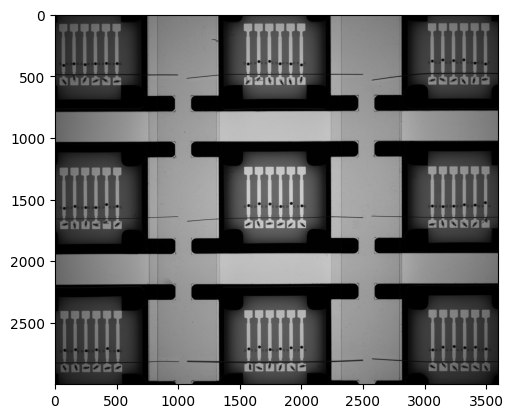

In [6]:
# Path definitions

datafolder = Path("/home/matthias/Videos/")
# For directories and subdirectories within the datafolder, if they contain images and do not have '_Cropped' in their name, add them to the list of folders to process
                                
inputfolder = datafolder.joinpath("230704_FeedingState_1_AM")

print(inputfolder.as_posix())
# Load the first frame
frame = cv2.imread(inputfolder.joinpath("image0.jpg").as_posix())
# Display the frame
plt.imshow(frame)

In [9]:
# For each directory in the datafolder, check if there is another directory with the same name and '_Cropped' appended
# If there is, skip this directory
# If there isn't, check if there are images in the directory

def check_integrity(folder, source_folder):
    if len(list(folder.iterdir())) != 9:
        return False
    source_image_count = len(list(source_folder.glob('*.png'))) + len(list(source_folder.glob('*.jpg')))
    for subfolder in folder.iterdir():
        if not subfolder.is_dir() or len(list(subfolder.iterdir())) != 6:
            return False
        for subsubfolder in subfolder.iterdir():
            if not subsubfolder.is_dir():
                return False
            image_count = len(list(subsubfolder.glob('*.png'))) + len(list(subsubfolder.glob('*.jpg')))
            if image_count != source_image_count:
                return False
    return True

def check_processed(data_folder):
    data_folder = Path(data_folder)
    for folder in data_folder.iterdir():
        if folder.is_dir() and not folder.name.endswith('_Cropped'):
            cropped_folder = folder.name + '_Cropped'
            cropped_folder_path = data_folder / cropped_folder
            if cropped_folder_path.exists():
                if check_integrity(cropped_folder_path, folder):
                    print(f"{folder.name} is already processed and its integrity is verified.")
                else:
                    print(f"{folder.name} is already processed but its integrity is not verified.")
            else:
                print(f"{folder.name} is not processed.")
                # call your image processing function here
                
check_processed(datafolder)

230704_FeedingState_1_AM is already processed but its integrity is not verified.
230705_FeedingState_2_AM is not processed.
230705_FeedingState_2_PM is not processed.
230706_FeedingState_3_PM is not processed.
230706_FeedingState_3_AM is not processed.
230704_FeedingState_1_PM is not processed.


In [4]:
inputfolder = Path("/Volumes/Ramdya-lab/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/Feeding_state/230704_FeedingState_1_AM_Cropped/")


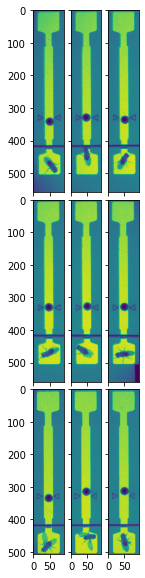

In [5]:
# For each folder and subfolder within the inputfolder, get the first image and store it in a list
import os
from PIL import Image


image_list = []

for root, dirs, files in os.walk(inputfolder.as_posix()):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_list.append(os.path.join(root, file))
            break

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.1,
                 )

for i in range(9):
    image = Image.open(image_list[i])
    grid[i].imshow(image)

plt.show()   
        

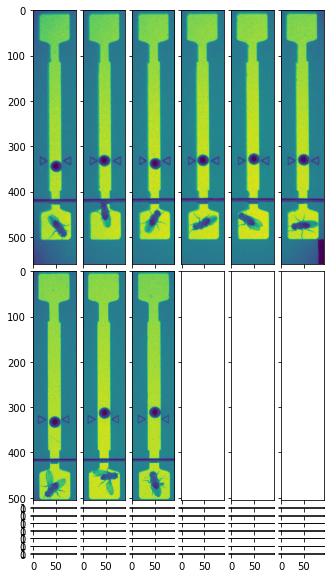

In [6]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(9, 6),
                 axes_pad=0.1,
                 )

for i in range(9):
    image = Image.open(image_list[i])
    grid[i].imshow(image)

plt.show()   